# 03-proximity_analysis (based on Script 18 pipeline)

The purpose of this notebook and notebook 03-proximity_analysis_2 is similar. Comparing original (no filter) vs v2 (filtering some amenities) proximity. __This process was simplified in notebooks starting with 'a', specially Notebook a-03-comparing_data.__

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


In [21]:
city = 'Monterrey'
nodes_update = True
pop_output = False
local_save = True
save_space = False

original_nearest = '../../../data/external/temporal_fromjupyter/02_pois_distance_node.gpkg'
filtered_nearest = '../../../data/external/temporal_fromjupyter/02_pois_distance_node_filtered.gpkg'

In [23]:
res_list=[9]

if nodes_update:
    cultural_dicc = {'denue_cines':[512130],'denue_museos':[712111, 712112],
                     'denue_bibliotecas':[519121,519122],'denue_centrocultural':[711312]}
else:
    cultural_dicc = {'denue_cines':[512130],'denue_museos':[712111, 712112]}   


#--------------- PREPARE DATA ---------- SET PARAMETER
    #This step sets the ejes, amenidades, sources and codes for further analysis
            #{Eje (e):
            #            {Amenity (a):
            #                          {Sources (s):
            #                                           [Codes (c)]
            #                           }
            #             }
            #}
parameters = {'Escuelas':{'Preescolar':{'denue_preescolar':[611111, 611112]},
                          'Primaria':{'denue_primaria':[611121, 611122]},
                          'Secundaria':{'denue_secundaria':[611131, 611132]}
                         },
             'Servicios comunitarios':{'Salud':{'clues_primer_nivel':[8610]},
                                       'Guarderías':{'denue_guarderias':[624411, 624412]},
                                       'Asistencia social':{'denue_dif':[931610]}
                                      },
              'Comercio':{'Alimentos':{'denue_supermercado':[462111],
                                       'denue_abarrotes':[461110], 
                                       'denue_carnicerias': [461121, 461122, 461123],
                                       'sip_mercado':[4721]},
                          'Personal':{'denue_peluqueria':[812110]},
                          'Farmacias':{'denue_farmacias':[464111, 464112]},
                          'Hogar':{'denue_ferreteria_tlapaleria':[467111],
                                   'denue_art_limpieza':[467115]},
                          'Complementarios':{'denue_ropa':[463211, 463212, 463213, 463215, 463216, 463218],
                                             'denue_calzado':[463310], 
                                             'denue_muebles':[466111, 466112, 466113, 466114],
                                             'denue_lavanderia':[812210],
                                             'denue_revistas_periodicos':[465313],
                                             'denue_pintura':[467113]}
                         },
              'Entretenimiento':{'Social':{'denue_restaurante_insitu':[722511, 722512, 722513, 722514, 722519],
                                           'denue_restaurante_llevar':[722516, 722518, 722517],
                                           'denue_bares':[722412],
                                           'denue_cafe':[722515]},
                                 'Actividad física':{'sip_cancha':[93110],
                                                     'sip_unidad_deportiva':[93111],
                                                     'sip_espacio_publico':[9321],
                                                     'denue_parque_natural':[712190]},
                                 'Cultural':cultural_dicc   
                                } 
             }

In [19]:
# If need to measure nearest source for amenity, doesn't matter which, choose 'min'
# If need to measure access to all of the different sources in an amenity, choose 'max'

source_weight = {'Escuelas':{'Preescolar':'max', #There is only one source, no effect.
                             'Primaria':'max',  #There is only one source, no effect.
                             'Secundaria':'max'},  #There is only one source, no effect.
                 'Servicios comunitarios':{'Salud':'max',  #There is only one source, no effect.
                                           'Guarderías':'max', #There is only one source, no effect.
                                           'Asistencia social':'max'},  #There is only one source, no effect.
                 'Comercio':{'Alimentos':'min', # /////////////////////////////////////////////////////// Will choose min time to source because measuring access to nearest food source, doesn't matter which.
                             'Personal':'max', #There is only one source, no effect.
                             'Farmacias':'max', #There is only one source, no effect.
                             'Hogar':'min', # ////////////////////////////////////////////////////////// Will choose min time to source because measuring access to nearest source, doesn't matter which.
                             'Complementarios':'min'}, # /////////////////////////////////////////////// Will choose min time to source because measuring access to nearest source, doesn't matter which.
                 'Entretenimiento':{'Social':'max', # ////////////////////////////////////////////////// Will choose max time to source because measuring access to all of them.
                                    'Actividad física':'min', # //////////////////////////////////////// Will choose min time to source because measuring access to nearest source, doesn't matter which.
                                    'Cultural':'min'} # //////////////////////////////////////////////// Will choose min time to source because measuring access to nearest source, doesn't matter which.
                }

## Load data

### Load data - Area of interest

<Axes: >

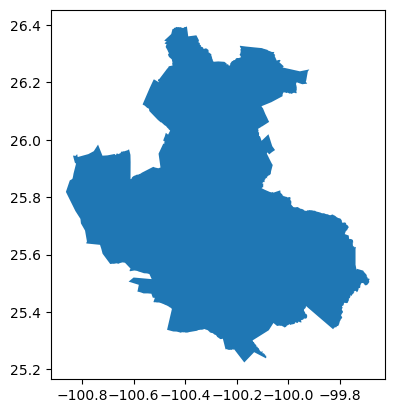

In [4]:
# Location of area of interest (Required)
schema = 'metropolis'
table = 'metro_gdf_2015'

query = f"SELECT * FROM {schema}.{table} WHERE \"city\" LIKE \'{city}%%\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
mun_gdf.set_crs("EPSG:4326",inplace=True)

# Create dissolved area of interest
mun_gdf = mun_gdf.to_crs("EPSG:6372")
aoi = mun_gdf.dissolve()
aoi = aoi.to_crs("EPSG:4326")

if save_space:
    del mun_gdf

aoi.plot()

### Load data - Original (and new) nodes_proximity

In [5]:
# Load original nodes_proximity for city
#schema = 'prox_analysis'
#table = 'nodes_proximity_2020'

#query = f"SELECT * FROM {schema}.{table} WHERE \"metropolis\" = \'{city}\'"
#original_nodes = aup.gdf_from_query(query, geometry_col='geometry')

# Format
#original_nodes.rename(columns={'amenity':'source',
#                                'metropolis':'city'},inplace=True)

#Show
#print(original_nodes.source.unique())
#print(original_nodes.shape)
#original_nodes.head(1)

In [6]:
original_nearest_gdf = gpd.read_file(original_nearest)

#Show
print(original_nearest_gdf.shape)
original_nearest_gdf.head(2)

(166633, 4)


,code,osmid,distance_node,geometry
0,237212.0,1684772514,43.357154,POINT (-100.20686 25.67193)
1,237312.0,3279477659,34.159095,POINT (-100.19833 25.67555)


In [33]:
prueba=original_nearest_gdf.loc[original_nearest_gdf.code==9321]
prueba.head(1)

,code,osmid,distance_node,geometry


In [7]:
if nodes_update:
    filtered_nearest_gdf = gpd.read_file(filtered_nearest)
    
    #Show
    print(filtered_nearest_gdf.code.unique())
    print(filtered_nearest_gdf.shape)
    filtered_nearest_gdf.head(1)

[711312. 931610. 519122. 519121.]
(363, 4)


Update nodes for comparison

In [8]:
if nodes_update:
    # Remove codes to update
    original_nearest_gdf_f = original_nearest_gdf.copy()
    for code in filtered_nearest_gdf.code.unique():
        original_nearest_gdf_f = original_nearest_gdf_f.loc[original_nearest_gdf_f.code != code]
    
    # Update codes
    nearest = pd.concat([original_nearest_gdf_f,filtered_nearest_gdf])

    if save_space:
        del original_nearest_gdf_f

else:
    nearest = original_nearest_gdf.copy()

# Show
print(nearest.shape)
nearest.head(1)

(166286, 4)


,code,osmid,distance_node,geometry
0,237212.0,1684772514,43.357154,POINT (-100.20686 25.67193)


## Proximity analysis

### Step 1: Download OSMnx network (G, nodes and edges)

In [10]:
# Download osmnx network (G, nodes and edges from bounding box of aoi)
G, nodes, edges = aup.create_osmnx_network(aoi,how='from_bbox')

Extracted min and max coordinates from the municipality. Polygon N:26.39517, S:25.22379, E-99.6862, W-100.8619.
Created OSMnx graph from bounding box.
Converted OSMnx graph to 240756 nodes and 612178 edges GeoDataFrame.
Filtered columns.
Column: osmid in nodes gdf, has a list in it, the column data was converted to string.
Column: lanes in nodes gdf, has a list in it, the column data was converted to string.
Column: name in nodes gdf, has a list in it, the column data was converted to string.
Column: highway in nodes gdf, has a list in it, the column data was converted to string.
Column: maxspeed in nodes gdf, has a list in it, the column data was converted to string.
Column: ref in nodes gdf, has a list in it, the column data was converted to string.
Column: access in nodes gdf, has a list in it, the column data was converted to string.
Column: width in nodes gdf, has a list in it, the column data was converted to string.
Column: service in nodes gdf, has a list in it, the column data

In [12]:
# Format to calculate nearest
nodes_gdf = nodes.set_crs("EPSG:4326")
edges_gdf = edges.set_crs("EPSG:4326")
nodes_gdf = nodes_gdf.set_index('osmid')
edges_gdf = edges_gdf.set_index(["u", "v", "key"])

### Step 3: Calculate distance to nearest source amenity for each node

In [13]:
# Create sources - code dicc out of main parameters dicc
sources = {}
for eje in parameters.keys():
    for amenity in parameters[eje]:
        for source in parameters[eje][amenity]:
            sources[source] = parameters[eje][amenity][source]

# Format
pois_distance_node = nearest.copy()
edges_gdf['length'].fillna(edges_gdf['length'].mean(),inplace=True)

# ELEMENTS NEEDED OUTSIDE THE LOOP - nodes_analysis is a nodes_gdf out of loop used in aup.calculate_distance_nearest_poi in each loop
nodes_analysis = nodes_gdf.reset_index().copy()
# ELEMENTS NEEDED OUTSIDE THE LOOP - nodes_sources is a nodes_gdf out of loop used to accumulate a final gdf with the minimal distance from each node to each source
nodes_sources = gpd.GeoDataFrame()
# ELEMENTS NEEDED OUTSIDE THE LOOP - Count
i = 0

# Loop that calculates distance from each node to each source (source by source)
for s in sources:
    
    # Locate pois data for current source
    source_gdf = gpd.GeoDataFrame()
    for cod in sources[s]:
        source_tmp = pois_distance_node[pois_distance_node['code']==cod]
        source_gdf = pd.concat([source_gdf,source_tmp])
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Loaded a total of {len(source_gdf)} points of interest of the source {s} for analisis.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    # Data for current amenity loop - df_temp: Each column will be a batch of procesed nodes.
    df_temp = nodes_gdf.copy()
    # Data for current amenity loop - nodes_distance: Minimum time/distance found in all batches will be added from df_min (within if/elif/else) to nodes_distance and finally to nodes_sources (outside loop)
    nodes_distance = nodes_gdf.copy()
    
    # In case there are no amenities of a certain type in the city
    if len(source_gdf) == 0:
        nodes_time = nodes_distance.copy()
        nodes_time['time'] = 0
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"0 points of interest of the source {s} found, time is NaN.")
        #-------------------------------------------------------------------------------------------------------------------------------------------------       
    
    # Elif, divide in batches processing (200 if the total number of pois is an exact multiple of 250, 250 otherwise)
    elif len(source_gdf) % 250:
        batch_size = len(source_gdf)/200
        for k in range(int(batch_size)+1):
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Starting range k = {k} of {int(batch_size)} for source {s}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            source_process = source_gdf.iloc[int(200*k):int(200*(1+k))].copy()
            nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges_gdf, s, 'osmid', wght='length')
            
            #A middle gdf is created whose columns will be the name of the amenity and the batch number it belongs to
            df_int = pd.DataFrame()
            df_int['dist_'+str(k)+s] = nodes_distance_prep['dist_'+s]
            
            #The middle gdf is merged into the previously created temporary gdf to store the data by node, each batch in a column.
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)
            
        # Once finished, drop the non-distance values from the temporary gdf
        df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)
        
        #We apply the min function to find the minimum value. This value is sent to a new df_min
        df_min = pd.DataFrame()
        df_min['dist_'+s] = df_temp.min(axis=1)
        
        #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store all final data
        nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)
        
        #Final data gets converted to time, assuming a walking speed of 4km/hr
        nodes_time = nodes_distance.copy()
        nodes_time['time'] = (nodes_time['dist_'+s]*60)/4000
        
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Calculated time from nodes to pois for a total of {len(nodes_distance)} nodes for source {s}.")
        #------------------------------------------------------------------------------------------------------------------------------------------------- 

    # Else, divide in batches processing (200 if the total number of pois is an exact multiple of 250, 250 otherwise)   
    else:
        batch_size = len(source_gdf)/250
        for k in range(int(batch_size)+1):
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Starting range k = {k} of {int(batch_size)} for source {s}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            source_process = source_gdf.iloc[int(250*k):int(250*(1+k))].copy()
            nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges_gdf, s, 'osmid', wght='length')
            
            #A middle gdf is created whose columns will be the name of the amenity and the batch number it belongs to
            df_int = pd.DataFrame()
            df_int['dist_'+str(k)+s] = nodes_distance_prep['dist_'+s]
            
            #The middle gdf is merged into the previously created temporary gdf to store the data by node, each batch in a column.
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)
            
        # Once finished, drop the non-distance values from the temporary gdf
        df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)
        
        #We apply the min function to find the minimum value. This value is sent to a new df_min
        df_min = pd.DataFrame()
        df_min['dist_'+s] = df_temp.min(axis=1)
        
        #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store all final data
        nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)
        
        #Final data gets converted to time, assuming a walking speed of 4km/hr
        nodes_time = nodes_distance.copy()
        nodes_time['time'] = (nodes_time['dist_'+s]*60)/4000
    
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Calculated time from nodes to pois for a total of {len(nodes_distance)} nodes for source {s}.")
        #-------------------------------------------------------------------------------------------------------------------------------------------------    
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Applying final formating to calculated nodes.")
    #----------------------------------------------------------------------------------------------------------------------------------------------------- 
    
    #Format nodes_distance
    nodes_time['source'] = s
    nodes_time['city'] = city
    nodes_time.reset_index(inplace=True)
    nodes_time = nodes_time.set_crs("EPSG:4326")
    nodes_time = nodes_time[['osmid','time','source','city','x','y','geometry']]
    
    #If it is the first round nodes_sources is created equal to nodes_distance (all nodes, one source)
    #If it is the second or more, the new nodes_distance is merged.
    #This way we obtain the final gdf of interest that will contain the minimum disstance to each type of amenity by column.
    if i == 0:
        nodes_sources = nodes_time.copy()
    else:
        nodes_sources = pd.concat([nodes_sources,nodes_time])
        
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Added time for source {s} to nodes_sources.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    i += 1

# Saves space in disk if instructed
if save_space:
    del nearest
    del nodes_gdf
    del nodes_analysis
    del source_tmp
    del source_gdf
    del df_temp
    del nodes_distance
    del nodes_time
    del source_process
    del nodes_distance_prep
    del df_int
    del df_min
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Saved space by deleting used data.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

Loaded a total of 1687 points of interest of the source denue_preescolar for analisis.
Starting range k = 0 of 8 for source denue_preescolar.
Starting range k = 1 of 8 for source denue_preescolar.
Starting range k = 2 of 8 for source denue_preescolar.
Starting range k = 3 of 8 for source denue_preescolar.
Starting range k = 4 of 8 for source denue_preescolar.
Starting range k = 5 of 8 for source denue_preescolar.
Starting range k = 6 of 8 for source denue_preescolar.
Starting range k = 7 of 8 for source denue_preescolar.
Starting range k = 8 of 8 for source denue_preescolar.
Calculated time from nodes to pois for a total of 240756 nodes for source denue_preescolar.
Applying final formating to calculated nodes.
Added time for source denue_preescolar to nodes_sources.
Loaded a total of 1490 points of interest of the source denue_primaria for analisis.
Starting range k = 0 of 7 for source denue_primaria.
Starting range k = 1 of 7 for source denue_primaria.
Starting range k = 2 of 7 for so

### Step 4 - Pop Data (Optional)

In [14]:
if pop_output:
    hex_socio_gdf = aup.create_popdata_hexgrid(aoi,pop_dir,pop_index_column,pop_column,res_list)
    if local_save:
        hex_socio_gdf.to_file(pop_save_dir, driver='GPKG')

### Step 4 - Transform nodes data

In [15]:
nodes = nodes_sources.copy()

#--------------- PREPARE DATA
#--------------- PREPARE DATA ---------- DELETE DUPLICATES AND CLEAN NODES
#This step keeps osmid, geometry and metropolis (without duplicates, keeping only one point for each node) to store times to each amenity source by node in following loop.
nodes_geom = nodes.drop_duplicates(subset='osmid', keep="last")[['osmid','geometry','city']].copy()

#--------------- PREPARE DATA ---------- REORGANIZE NODES DATA
#This step organizes data by nodes by changing (time to source amenities) from rows (1 column with source amenity name + 1 column with time data) 
#to columns (1 column with time data named after its source amenity)
nodes_analysis = nodes_geom.copy()

for source_amenity in list(nodes.source.unique()):
    nodes_tmp = nodes.loc[nodes.source == source_amenity,['osmid','time']]
    nodes_tmp = nodes_tmp.rename(columns={'time':source_amenity})
    # Search for amenities that aren't present in the city (with all values marked as 0) and change them to NaN
    if nodes_tmp[source_amenity].mean() == 0:
        nodes_tmp[source_amenity] = np.nan
    nodes_analysis = nodes_analysis.merge(nodes_tmp, on='osmid')

if save_space:
    del nodes
    del nodes_sources
    del nodes_geom
    del nodes_tmp
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Saved space by deleting used data.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Transformed nodes data.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

#Show
print(nodes_analysis.shape)
nodes_analysis.head(2)

Saved space by deleting used data.
Transformed nodes data.
(240756, 35)


,osmid,geometry,city,denue_preescolar,denue_primaria,denue_secundaria,clues_primer_nivel,denue_guarderias,denue_dif,denue_supermercado,...,denue_bares,denue_cafe,sip_cancha,sip_unidad_deportiva,sip_espacio_publico,denue_parque_natural,denue_cines,denue_museos,denue_bibliotecas,denue_centrocultural
0,316859918,POINT (-100.03709 25.63510),Monterrey,42.918195,41.380245,67.382085,NaN,71.916915,94.03329,83.787735,...,91.03095,32.714010,NaN,NaN,NaN,313.001565,127.370745,119.10177,121.664295,100.265655
1,316859925,POINT (-99.99532 25.60642),Monterrey,8.718345,12.011325,18.248325,NaN,34.945365,13.46412,34.494585,...,19.90335,27.298335,NaN,NaN,NaN,388.446705,53.487945,45.21897,194.748780,26.382855


### Step 4 - Create definitions (previously idx_15min) dicc

In [16]:
# Create definitions dicc out of main parameters dicc:
definitions = {}
for eje in parameters.keys():
    # Temporary dicc stores amenity:[source_list] for each eje
    tmp_dicc = {}
    
    for amenity in parameters[eje]:
        items_lst = []
        items = list(parameters[eje][amenity].items())
        
        for item in items:
            items_lst.append(item[0])
            
        tmp_dicc[amenity] = items_lst
     
    # Each eje gets assigned its own tmp_dicc
    definitions[eje] = tmp_dicc

### Step 4 - Fill for missing amenities

In [17]:
#--------------- PREPARE DATA ---------- FILL MISSING COLUMNS (In case there is a source amenity not available in a city)
all_sources = []

# Gather all possible sources
for eje in definitions.keys():
    for amenity in definitions[eje].values():
        for source in amenity:
            all_sources.append(source)
            
# If source not in currently analized city, fill column with np.nan
column_list = list(nodes_analysis.columns)
missing_sourceamenities = []

for s in all_sources:
        if s not in column_list:
            nodes_analysis[s] = np.nan
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"{s} source amenity is not present in {city}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            missing_sourceamenities.append(s)
            
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print(f"Finished missing source amenities analysis. {len(missing_sourceamenities)} not present source amenities were added as np.nan columns")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Finished missing source amenities analysis. 0 not present source amenities were added as np.nan columns


### Step 4 - Amenities analysis

In [20]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Starting proximity to amenities analysis by node.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

#--------------- PROCESS DATA 
#--------------- PROCESS DATA ---------- Max time calculation
#This step calculates times by amenity

column_max_all = [] # list with all max index column names
column_max_ejes = [] # list with ejes index column names

#Goes through each eje in dictionary:
for e in definitions.keys():

    #Appends to 3 lists currently examined eje
    column_max_all.append('max_'+ e.lower())
    column_max_ejes.append('max_'+ e.lower())
    column_max_amenities = [] # list with amenities in current eje

    #Goes through each amenity of current eje:
    for a in definitions[e].keys():

        #Appends to 2 lists currently examined amenity:
        column_max_all.append('max_'+ a.lower())
        column_max_amenities.append('max_'+ a.lower())

        #Calculates time to currently examined amenity:
        #If weight is less than number of sources of amenity, choose minimum time to sources.
        if source_weight[e][a] == 'min': 
            nodes_analysis['max_'+ a.lower()] = nodes_analysis[definitions[e][a]].min(axis=1)
        #Else, choose maximum time to sources.
        else:
            nodes_analysis['max_'+ a.lower()] = nodes_analysis[definitions[e][a]].max(axis=1)

    #Calculates time to currently examined eje (max time of its amenities):
    nodes_analysis['max_'+ e.lower()] = nodes_analysis[column_max_amenities].max(axis=1) 

index_column = 'max_time' # column name for maximum time data

#Add to column_max_all list the attribute 'max_time'
column_max_all.append(index_column)

#Assigns "max_time" the max time for all ejes
nodes_analysis[index_column] = nodes_analysis[column_max_ejes].max(axis=1)     

#Add to column_max_all list the attributes 'osmid' and 'geometry' to filter nodes_analysis with the column_max_all list.
column_max_all.append('osmid')
column_max_all.append('geometry')
nodes_analysis_filter = nodes_analysis[column_max_all].copy()

if save_space:
    del nodes_analysis
    
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Calculated proximity to amenities data by node.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Starting proximity to amenities analysis by node.
Calculated proximity to amenities data by node.


In [27]:
nodes_analysis_filter.head(1)

,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,max_comercio,max_alimentos,...,max_farmacias,max_hogar,max_complementarios,max_entretenimiento,max_social,max_actividad física,max_cultural,max_time,osmid,geometry
0,67.382085,42.918195,41.380245,67.382085,94.03329,NaN,71.916915,94.03329,61.38699,25.221405,...,61.38699,28.07103,43.12758,313.001565,91.03095,313.001565,100.265655,313.001565,316859918,POINT (-100.03709 25.63510)


### Step 4 - Group by hex (mean data)

In [24]:
hex_idx = gpd.GeoDataFrame()

for res in res_list:
    
    #/////////////////////////////////////////////////////////////////////////// HEXGRID DEPENDS ON POP DATA BEING CALCULATED OR NOT ///////////////////////////////////////////////////////////////////////////
    # If pop_output is true, loads previously created hexgrid with pop data
    if pop_output:
        # Load hexgrid
        hex_pop = hex_socio_gdf.loc[hex_socio_gdf['res'] == res]
        
        #Function group_by_hex_mean requires ID to include resolution
        hex_pop.rename(columns={'hex_id':f'hex_id_{res}'},inplace=True)
        
        # Create hex_tmp
        hex_pop = hex_pop.set_crs("EPSG:4326")
        hex_tmp = hex_pop[[f'hex_id_{res}','geometry']].copy()
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Loaded pop hexgrid of resolution {res}")
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        
    # If pop_output is false, creates hexgrid
    else:
        # Create hexgrid (which already has ID_res)
        hexgrid = aup.create_hexgrid(aoi,res)
        
        # Create hex_tmp
        hexgrid = hexgrid.set_crs("EPSG:4326")
        hex_tmp = hexgrid.copy()
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Created hexgrid of resolution {res}")
        #-------------------------------------------------------------------------------------------------------------------------------------------------
        
    #/////////////////////////////////////////////////////////////////////////// HEXGRID DEPENDS ON POP DATA BEING CALCULATED OR NOT ///////////////////////////////////////////////////////////////////////////
    
    # group data by hex
    hex_res_idx = aup.group_by_hex_mean(nodes_analysis_filter, hex_tmp, res, index_column)
    hex_res_idx = hex_res_idx.loc[hex_res_idx[index_column]>0].copy()
    
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print(f"Grouped nodes data by hexagons res {res}")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
    #////////////////////////////////////////////////////////////////////////////////// ADD POP DATA IF POP DATA IS CONSIDERED /////////////////////////////////////////////////////////////////////////////////
    # Add pop data
    if pop_output:
        pop_list = [f'hex_id_{res}','pobtot','dens_pob_ha']
        hex_res_pop = pd.merge(hex_res_idx, hex_pop[pop_list], on=f'hex_id_{res}')
    else:
        hex_res_pop = hex_res_idx.copy()
    #////////////////////////////////////////////////////////////////////////////////// ADD POP DATA IF POP DATA IS CONSIDERED /////////////////////////////////////////////////////////////////////////////////    
    
    # After funtion group_by_hex_mean we can remove res from ID and set as a column
    hex_res_pop.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
    hex_res_pop['res'] = res

    hex_idx = hex_idx.append(hex_res_pop)
        
    #-----------------------------------------------------------------------------------------------------------------------------------------------------    
    print(f"Saved grouped data by hexagons res {res}")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    
if save_space:
    if pop_output:
        del hex_socio_gdf #pop_output=True
        del hex_pop #pop_output=True
        del hex_tmp
        del nodes_analysis_filter
        del hex_res_idx
        del hex_res_pop #pop_output=True
    else:
        del hexgrid #pop_output=False
        del hex_tmp
        del nodes_analysis_filter
        del hex_res_idx
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Saved space by deleting used data.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

Created hexgrid of resolution 9


TypeError: agg function failed [how->mean,dtype->geometry]

### Step 4 - Relculate ejes max times by hexagon

In [ ]:
#--------------- PROCESS DATA ---------- RE-CALCULATE MAX TIMES BY HEXAGON (ALL)
# This step recalculates max time to each eje from max times to calculated amenities and max_time from max eje
column_max_ejes = [] # list with ejes index column names

#Goes (again) through each eje in dictionary:
for e in definitions.keys():

    column_max_ejes.append('max_'+ e.lower())
    column_max_amenities = [] # list with amenities in current eje

    #Goes (again) through each amenity of current eje:    
    for a in definitions[e].keys():

        column_max_amenities.append('max_'+ a.lower())

    #Re-calculates time to currently examined eje (max time of its amenities):        
    hex_idx['max_'+ e.lower()] = hex_idx[column_max_amenities].max(axis=1)

#-----------------------------------------------------------------------------------------------------------------------------------------------------
print('Finished recalculating times in hexagons')
#-----------------------------------------------------------------------------------------------------------------------------------------------------   

### Step 4 - Calculate index and add aditional data

In [ ]:
#--------------- PROCESS DATA ---------- INDEX, MEDIAN AND MEAN CALCULATION (ALL)

#Define function
def apply_sigmoidal(x):
    if x == -1:
        return -1
    elif x > 1000:
        return 0
    else:
        val = aup.sigmoidal_function(0.1464814753435666, x, 30)
        return val

#Apply function to amenities columns without ejes ---------------------------------------------///// En lugar de pasarle la lista de amenidades, se crea la lista de amenidades desde column_max_all
max_amenities_cols = [i for i in column_max_all if i not in column_max_ejes]
max_amenities_cols.remove('max_time')
max_amenities_cols.remove('osmid')
max_amenities_cols.remove('geometry')

idx_amenities_cols = [] # list with idx amenity column names
for ac in max_amenities_cols:
    idx_col = ac.replace('max','idx')
    hex_idx[idx_col] = hex_idx[ac].apply(apply_sigmoidal)
    idx_amenities_cols.append(idx_col)

# Add final data
hex_idx[index_column] = hex_idx[column_max_ejes].max(axis=1)
hex_idx['mean_time'] = hex_idx[max_amenities_cols].mean(axis=1)
hex_idx['median_time'] = hex_idx[max_amenities_cols].median(axis=1)
hex_idx['idx_sum'] = hex_idx[idx_amenities_cols].sum(axis=1)
hex_idx['city'] = city
#-----------------------------------------------------------------------------------------------------------------------------------------------------    
print('Finished calculating index, mean and median time')
#-----------------------------------------------------------------------------------------------------------------------------------------------------

### Step 4 - Final format

In [ ]:
#--------------- FINAL FORMAT ----------
#--------------- FINAL FORMAT ---------- REORDER COLUMNS

# First elements of ordered list - ID and geometry
first_elements = ['hex_id','res','geometry']

# Second elements of ordered list - max_ejes and max_amenities removing max_time, osmid and geometry.
column_max_ejes_amenities = column_max_all.copy()
column_max_ejes_amenities.remove('max_time')
column_max_ejes_amenities.remove('osmid')
column_max_ejes_amenities.remove('geometry')

# Third elements of ordered list are listed in idx_amenities_cols

# Fourth elements of ordered list - Mean, median, max and idx
fourth_elements = ['mean_time', 'median_time', 'max_time', 'idx_sum']

# Fifth elements - If pop is calculated - Pop data
fifth_elements = ['pobtot', 'dens_pob_ha']

# Last element - City data
last_element = ['city']

if pop_output:
    final_column_ordered_list = first_elements + column_max_ejes_amenities + idx_amenities_cols + fourth_elements + fifth_elements + last_element
else:
    final_column_ordered_list = first_elements + column_max_ejes_amenities + idx_amenities_cols + fourth_elements + last_element
    
hex_idx_city = hex_idx[final_column_ordered_list]

if save_space:
    del hex_idx
    
#---------------------------------------------------------------------------------------------------------------------------------------------------------
print('Finished final format')
#---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
if local_save:
    if nodes_update:
        hex_idx_city.to_file('../../../data/external/temporal_fromjupyter/04_proximityanalysis_hexres9_filtered.gpkg', driver='GPKG')
    else:
        hex_idx_city.to_file('../../../data/external/temporal_fromjupyter/04_proximityanalysis_hexres9.gpkg', driver='GPKG')

# Missing SIP and CLUES amenities

(878, 2)


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,code,geometry
0,8610,POINT (-100.28076 25.34542)
2,8610,POINT (-100.11454 25.37526)


In [36]:
# Creates query to download DENUE from the metropolitan area or capital
query = f"SELECT * FROM denue.sip_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
sip = aup.gdf_from_query(query, geometry_col='geometry')

sip_amenities = {'GEOGRAFICO':['Mercado','Plaza'], 
                 'TIPO':['Cancha','Unidad Deportiva','Áreas Verdes','Jardín','Parque']}

sip_amenities_codes = {
    #sip_mercado
    'Mercado':4721,
    #sip_cancha                   
    'Cancha':93110,
    #sip_unidad_deportiva                   
    'Unidad Deportiva':93111,
    #sip_espacio_publico
    'Áreas Verdes':9321,    
    'Jardín':9321,    
    'Parque':9321, 
    'Plaza':9321}    
    
# Iterate over sip_amenities and filter sip gdf
sip_pois = gpd.GeoDataFrame()

for col in sip_amenities:
    for amenity in sip_amenities[col]:
        sip_tmp = sip.loc[sip[col] == amenity]
        sip_tmp.loc[:,'code'] = sip_amenities_codes[amenity]
        sip_pois = pd.concat([sip_pois,sip_tmp])

#Format
sip_pois = sip_pois[['code','geometry']]

# Saves space in disk if instructed
if save_space:
    del sip

# Show
print(sip_pois.shape)
sip_pois.head(2)

(5070, 2)


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

,code,geometry
2056,4721,POINT (-100.31852 25.66898)
2370,4721,POINT (-100.31708 25.68795)


In [37]:
pois = pd.concat([clues_pois,sip_pois])

# Saves space in disk if instructed
if save_space:
    del clues_pois
    del sip_pois

# Show
print(pois.shape)
pois.head(2)

(5948, 2)


,code,geometry
0,8610,POINT (-100.28076 25.34542)
2,8610,POINT (-100.11454 25.37526)


In [39]:
# Filter pois for aoi
pois_aoi = gpd.sjoin(pois,aoi,how='inner')
pois = pois_aoi[['code','geometry']]

# Format to calculate nearest
#nodes_gdf = nodes.set_crs("EPSG:4326")
#edges_gdf = edges.set_crs("EPSG:4326")
#nodes_gdf = nodes_gdf.set_index('osmid')
#edges_gdf = edges_gdf.set_index(["u", "v", "key"])

# Calculate nearest
nearest_sipclues = aup.find_nearest(G, nodes_gdf, pois, return_distance= True)

#---------------------------------------------------------------------------------------------------------------------------------------------------------
print("Calculated distances from pois to nearest node.")
#---------------------------------------------------------------------------------------------------------------------------------------------------------

# Saves space in disk if instructed
if save_space:
    del nodes
    del edges
    #-----------------------------------------------------------------------------------------------------------------------------------------------------
    print("Saved space by deleting used data.")
    #-----------------------------------------------------------------------------------------------------------------------------------------------------

#Show
print(nearest_sipclues.shape)
nearest_sipclues.head(2)

NameError: name 'nodes_gdf' is not defined